### 导入包

In [94]:
import warnings
warnings.filterwarnings("ignore")

In [95]:
import scanpy as sc
import pandas as pd
import seaborn as sns
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import metrics

### 数据加载

In [96]:
annData = sc.read_h5ad("dataset2.h5ad")

In [97]:
annData.var_names_make_unique()
annData.obs_names_make_unique()

In [98]:
annData.obs

,domain,cell_type
cells,,
09L_GTTAGAACAGAT_RNA,scRNA-seq,E6Tle4
09I_CATAGCTCAACG_RNA,scRNA-seq,E2Rasgrf2
09G_TTACAGGCAGGT_RNA,scRNA-seq,InP
09B_CTATGGGCGTGC_RNA,scRNA-seq,E4Il1rapl2
09L_AGTGATTGTTCG_RNA,scRNA-seq,Peri
...,...,...
09E_CCTGCTCGTCAC_RNA,scRNA-seq,Peri
09E_TGAGCACCTCCT_RNA,scRNA-seq,E5Parm1
09E_CCGGACTCGATC_RNA,scRNA-seq,E3Rorb


输出annData相关信息：

In [99]:
annData

AnnData object with n_obs × n_vars = 9190 × 28930
    obs: 'domain', 'cell_type'

从上述输出可以看出，这个数据集总共有9190个细胞，28930个基因。

### 数据过滤

首先查看细胞表达基因数量

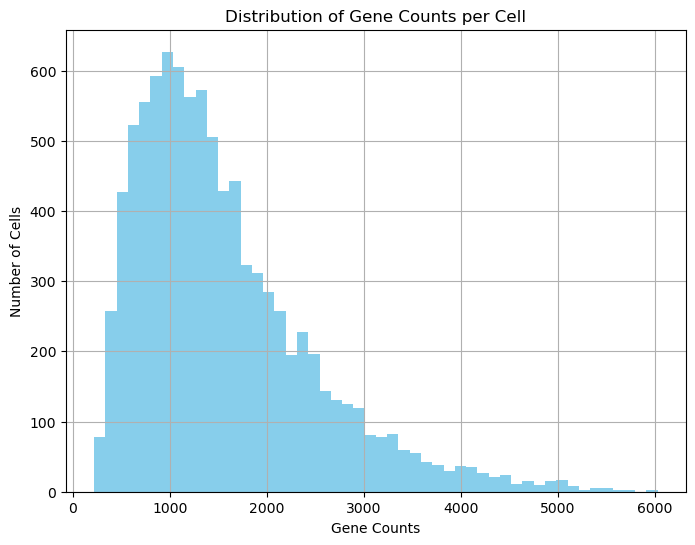

In [100]:
#可视化数据
#表达的基因对应的值为1，加和可以得到每个细胞表达了多少基因
gene_counts_per_cell=annData.X.sum(axis=1)
plt.figure(figsize=(8, 6))
plt.hist(gene_counts_per_cell, bins=50, color='skyblue')
plt.xlabel('Gene Counts')
plt.ylabel('Number of Cells')
plt.title('Distribution of Gene Counts per Cell')
plt.grid(True)
plt.show()

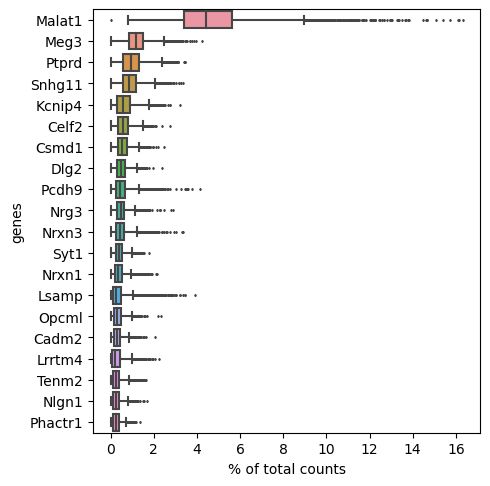

In [101]:
sc.pl.highest_expr_genes(annData, n_top=20)
#展示在所有的细胞当中表达占比最高的20个基因

接下来可视化每个基因表达的细胞数量：

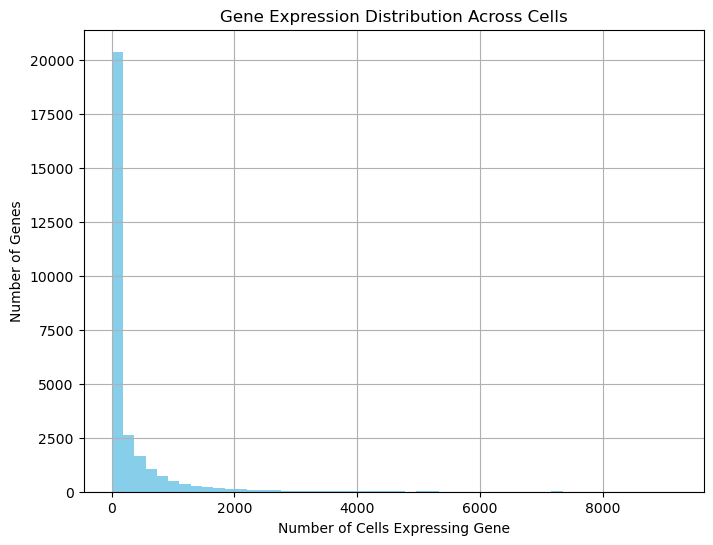

In [102]:
# 绘制直方图
# 计算每个基因的表达细胞数量
cells_expressed_per_gene = annData.X.getnnz(axis=0)
plt.figure(figsize=(8, 6))
plt.hist(cells_expressed_per_gene, bins=50, color='skyblue')
plt.xlabel('Number of Cells Expressing Gene')
plt.ylabel('Number of Genes')
plt.title('Gene Expression Distribution Across Cells')
plt.grid(True)
plt.show()

进行初步筛选：去除表达基因200以下的细胞和在3个细胞以下表达的基因：

In [103]:
sc.pp.filter_genes(annData,min_cells=3)
#去除在3个细胞以下表达的基因

### 数据归一化
- 目的：
  - 使数据接近正态分布
  - 确保数据的尺度一致性
- 方法：
  - 移位对数变换：有利于稳定方差，以利于后续降维和差异表达基因的识别
  - 皮尔森近似残差：保留生物学差异，并鉴定稀有细胞类型

In [104]:
#将基因计数（X）复制到了counts的层中
annData.layers['counts']=annData.X.copy()

#### 基于delta的移位对数

In [105]:
#inplace=False表示此操作不会更改原始的AnnData对象，而是返回一个新的对象
scales_counts = sc.pp.normalize_total(annData, target_sum=None, inplace=False)
#对经过归一化处理后的数据进行log1p转换，并将结果存储在AnnData对象的layers中的"log1p_norm"层
annData.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

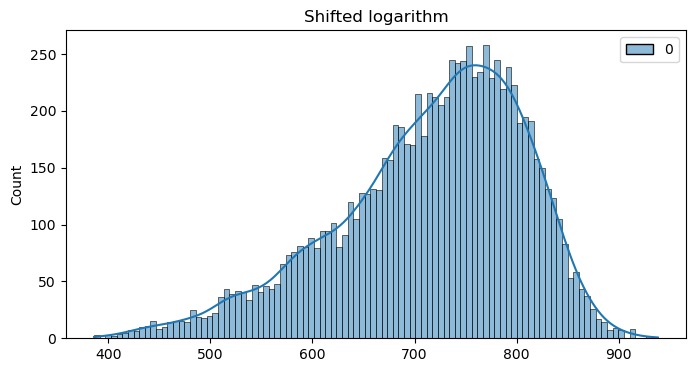

In [106]:
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
p1 = sns.histplot(annData.layers["log1p_norm"].sum(1), bins=100, kde=True, ax=axes)
axes.set_title("Shifted logarithm")
plt.show()

In [107]:
annData.layers["log1p_norm"].max()

5.3913455

从图中可以看出，该方法使结果倾向于正态分布

#### 皮尔森残差

In [108]:
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(annData, inplace=False)
#copy默认为true
annData.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

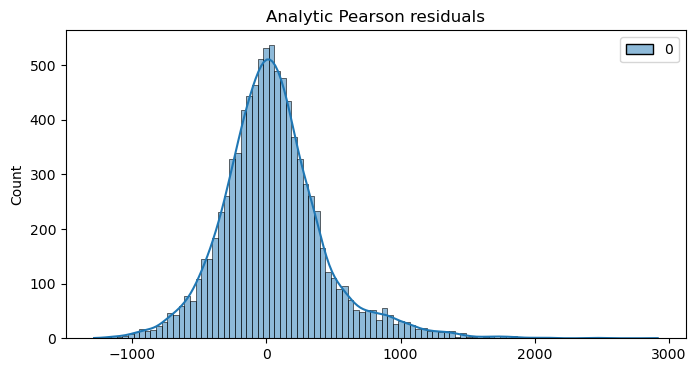

In [109]:
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
p2 = sns.histplot(
    annData.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=True, ax=axes
)
axes.set_title("Analytic Pearson residuals")
plt.show()

In [110]:
annData.layers["analytic_pearson_residuals"].max()

95.86449

归一化效果较好，同时对数据进行了缩放，将数据范围缩放到了-1000到1000之间

### 特征基因选择

从上述分析可以看出，一个细胞表达的基因大概是1000个左右，其中包含了一些不太具有实际意义的基因
- 大多数包含0计数
- 许多细胞中普遍出现

以上两种细胞在实际的分析中将不具有实际意义，所以现在的任务是计算出高可变基因（特征基因），排除那些不具有分析意义的基因，避免影响后续的聚类

#### 基于基因归一化方差

In [111]:
annData_var_num=sc.pp.highly_variable_genes(
    annData, 
    #指定用于识别高度可变基因的算法或方法的类型或名称，
    flavor="seurat_v3",
    #用于指定所用的数据层，在layer上分析，基于原始数据
    layer='counts',
    #表示要识别作为高度可变基因的前n个基因
    n_top_genes=2000,
    #指定是否仅在数据子集上计算高度可变性
    subset=False,
    inplace=False,
)
#将结果存储到var层中highly_variable_var部分
annData.var["highly_variable_var"]=annData_var_num['highly_variable']

In [112]:
annData_var_num['highly_variable'].value_counts()

highly_variable
False    21350
True      2000
Name: count, dtype: int64

In [113]:
annData_var_num

,means,variances,highly_variable_rank,variances_norm,highly_variable
genes,,,,,
0610005C13Rik,0.001415,0.001413,NaN,0.958600,False
0610009B22Rik,0.017301,0.022228,1520.0,1.125606,True
0610009E02Rik,0.014799,0.017193,NaN,1.023283,False
0610009L18Rik,0.016540,0.020403,NaN,1.082445,False
0610010F05Rik,0.157563,0.197176,NaN,1.005698,False
...,...,...,...,...,...
Ifitm5,0.000326,0.000326,NaN,0.999489,False
Gm43567,0.000435,0.000653,166.0,1.482551,True
Gm7648,0.000326,0.000326,NaN,0.999489,False


#### 基于基因皮尔森近似残差

In [114]:
annData_pearson_num=sc.experimental.pp.highly_variable_genes(
    annData, 
    #指定用于识别高度可变基因的算法或方法的类型或名称，
    flavor="pearson_residuals",
    #用于指定所用的数据层
    layer='counts',
    #表示要识别作为高度可变基因的前n个基因
    n_top_genes=2000,
    #指定是否仅在数据子集上计算高度可变性
    subset=False,
    inplace=False,
)
#将结果存储到var层中highly_variable_pearson部分
annData.var["highly_variable_pearson"]=annData_pearson_num['highly_variable']

In [115]:
annData_pearson_num['highly_variable'].value_counts()

highly_variable
False    21350
True      2000
Name: count, dtype: int64

In [116]:
annData_pearson_num

,means,variances,residual_variances,highly_variable_rank,highly_variable
genes,,,,,
0610005C13Rik,0.001415,0.001413,1.031214,NaN,False
0610009B22Rik,0.017301,0.022228,1.399373,NaN,False
0610009E02Rik,0.014799,0.017193,1.084670,NaN,False
0610009L18Rik,0.016540,0.020403,1.331709,NaN,False
0610010F05Rik,0.157563,0.197176,1.182030,NaN,False
...,...,...,...,...,...
Ifitm5,0.000326,0.000326,1.410435,NaN,False
Gm43567,0.000435,0.000653,1.550811,1436.0,True
Gm7648,0.000326,0.000326,0.546526,NaN,False


In [117]:
annData

AnnData object with n_obs × n_vars = 9190 × 23350
    obs: 'domain', 'cell_type'
    var: 'n_cells', 'highly_variable_var', 'highly_variable_pearson'
    layers: 'counts', 'log1p_norm', 'analytic_pearson_residuals'

### 数据降维

上一步中，已经通过特征基因的选择对数据的维度进行了初步降低，将其中比较能代表数据（或者说区别数据）的那一部分特征筛选出来

同时已知，高纬度状态下，数据中会包含更多的噪声和冗余。

所以，接下来，我们要通过使用降维算法进一步降低数据的维度，以便降低数据复杂性和进行可视化。

#### PCA线性降维
PCA是主成分分析法，它通过对原始数据集进行正交变换，创建一组新的无关变量，即主成分（PCs）

PCs是原始数据集中特征的线性组合，并按照方差的递减顺序进行排名以定义变换，通常第一主成分的方差最大。

In [118]:
annData.var.head()

,n_cells,highly_variable_var,highly_variable_pearson
genes,,,
0610005C13Rik,13,False,False
0610009B22Rik,137,True,False
0610009E02Rik,125,False,False
0610009L18Rik,135,False,False
0610010F05Rik,1212,False,False


In [119]:
#将原始数据存放在.raw中，注意.raw是一个只读属性，不可以在其上做更改
annData.raw=annData.copy()

获取只有高变基因的数据集

In [120]:
#采用皮尔森残差的结果
#保留 annData.var 中 "highly_variable_pearson" 列值为 True 的列（特征）
#并将选择后的数据重新赋值给 annData，覆盖掉原始数据。
annData=annData[:,annData.var["highly_variable_pearson"]==True]

In [121]:
#手动创建一个变量，这个变量就可以进行更改然后再存回layer层中
annData_scaled=annData.copy()

In [122]:
sc.pp.scale(annData_scaled,max_value=10)

In [123]:
#scanpy中scale后的值默认取代.X，所以此时将X放入layers中，不改变原数据
annData.layers["scaled"]=annData_scaled.X

In [124]:
annData

AnnData object with n_obs × n_vars = 9190 × 2000
    obs: 'domain', 'cell_type'
    var: 'n_cells', 'highly_variable_var', 'highly_variable_pearson'
    layers: 'counts', 'log1p_norm', 'analytic_pearson_residuals', 'scaled'

接下来基于scaled层进行pca运算

In [125]:
copy_data1=annData.copy()
copy_data1.X=annData.layers["scaled"]
#copy_data1 = sc.AnnData(X=annData.layers["scaled"])

In [126]:
#执行主成分分析
#svd_solver设定为奇异值分解的求解器
#n_comps为计算的主成分数量
sc.pp.pca(copy_data1, svd_solver='arpack', n_comps=50)

In [127]:
copy_data1

AnnData object with n_obs × n_vars = 9190 × 2000
    obs: 'domain', 'cell_type'
    var: 'n_cells', 'highly_variable_var', 'highly_variable_pearson'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'log1p_norm', 'analytic_pearson_residuals', 'scaled'

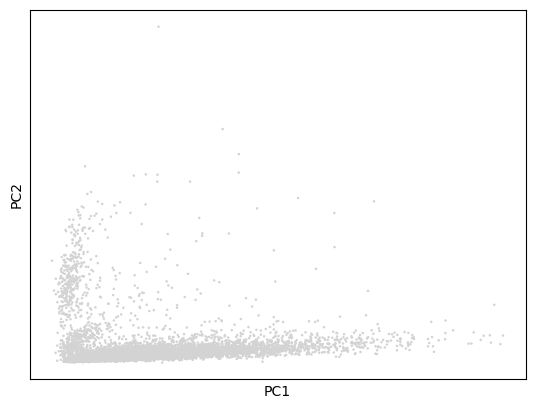

In [128]:
#由于最后的主成分仍然有50，依旧是高维数据，可视化后数据不直观
sc.pl.pca(copy_data1)
#这个应该是可以加颜色的，但是我一加就报错，所以我严重怀疑我电脑有问题
#（是的我运行不出来就是电脑的错）
# 我讨厌他
# 
# sc.pl.pca(copy_data1,color='X_pca')

In [129]:
#将结果存入原数据中
annData.obsm["scaled|X_pca"]=copy_data1.obsm["X_pca"]

In [130]:
annData

AnnData object with n_obs × n_vars = 9190 × 2000
    obs: 'domain', 'cell_type'
    var: 'n_cells', 'highly_variable_var', 'highly_variable_pearson'
    obsm: 'scaled|X_pca'
    layers: 'counts', 'log1p_norm', 'analytic_pearson_residuals', 'scaled'

使用原始数据进行pca主成分分析

In [131]:
copy_data2=annData.copy()
copy_data2.X=annData.layers["counts"]
#copy_data2 = sc.AnnData(X=annData.layers["counts"])

In [132]:
sc.pp.pca(copy_data2, svd_solver='arpack', n_comps=50)

In [133]:
copy_data2

AnnData object with n_obs × n_vars = 9190 × 2000
    obs: 'domain', 'cell_type'
    var: 'n_cells', 'highly_variable_var', 'highly_variable_pearson'
    uns: 'pca'
    obsm: 'scaled|X_pca', 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'log1p_norm', 'analytic_pearson_residuals', 'scaled'

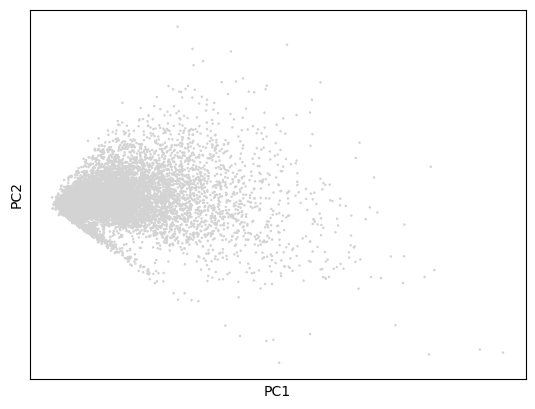

In [134]:
sc.pl.pca(copy_data2)
# 这个同上，大概是我电脑的问题
# 如果实在不行的话你再打回来我改改吧
# T^T T^T T^T

In [135]:
annData.obsm["original|X_pca"]=copy_data2.obsm["X_pca"]

In [136]:
annData

AnnData object with n_obs × n_vars = 9190 × 2000
    obs: 'domain', 'cell_type'
    var: 'n_cells', 'highly_variable_var', 'highly_variable_pearson'
    obsm: 'scaled|X_pca', 'original|X_pca'
    layers: 'counts', 'log1p_norm', 'analytic_pearson_residuals', 'scaled'

#### 非线性降维

首先基于细胞的主成分构建领域图，细胞的主成分存储在layers["scaled|X_pca"]中

函数：
```
def neighbors(
    adata: AnnData,
    n_neighbors: int = 15,
    n_pcs: int | None = None,
    use_rep: str | None = None,
    knn: bool = True,
    random_state: AnyRandom = 0,
    method: _Method | None = 'umap',
    metric: _Metric | _MetricFn = 'euclidean',
    metric_kwds: Mapping[str, Any] = MappingProxyType({}),
    key_added: str | None = None,
    copy: bool = False
) -> (AnnData | None)
```
常用参数：
- n_neighbors:指定要计算的邻居数量
- n_pcs:指定要使用的主成分数量
- use_rep:指定特定的数据
- method:可以选择`gauss`或者`umap`，计算邻居关系的方法

In [137]:
#邻居数量为15，主成分数量为50
sc.pp.neighbors(annData,n_neighbors=15,n_pcs=50,use_rep="scaled|X_pca")

In [138]:
annData

AnnData object with n_obs × n_vars = 9190 × 2000
    obs: 'domain', 'cell_type'
    var: 'n_cells', 'highly_variable_var', 'highly_variable_pearson'
    uns: 'neighbors'
    obsm: 'scaled|X_pca', 'original|X_pca'
    layers: 'counts', 'log1p_norm', 'analytic_pearson_residuals', 'scaled'
    obsp: 'distances', 'connectivities'

##### UMAP

In [139]:
#使用umap进行降维处理，最后结果存储于annData.obsm['X_umap']中
sc.tl.umap(annData)

In [140]:
annData

AnnData object with n_obs × n_vars = 9190 × 2000
    obs: 'domain', 'cell_type'
    var: 'n_cells', 'highly_variable_var', 'highly_variable_pearson'
    uns: 'neighbors', 'umap'
    obsm: 'scaled|X_pca', 'original|X_pca', 'X_umap'
    layers: 'counts', 'log1p_norm', 'analytic_pearson_residuals', 'scaled'
    obsp: 'distances', 'connectivities'

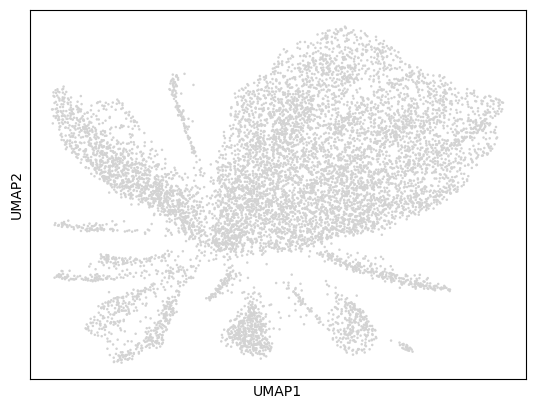

In [141]:
#可视化umap非线性降维后的结果
#sc.pl.umap(annData,color=['X_umap'])
# |
# |
# |
# |
# ——————>>>>>这个按道理是没问题的，但是我运行不出来，好像说是我电脑版本不太兼容，你们可以试试，不行就删掉他吧*_*
#######
# 不加颜色运行出来下面这个图，但是没有颜色（）
sc.pl.umap(annData)

##### t-SNE

In [142]:
#使用tsne进行降维处理，最后结果存储于annData.obsm['X_tsne']中
#sc.tl.tsne(annData,use_rep='X_pca')
# |
# |
# |
# |
# ——————>>>>>这个按道理应该也是没问题的，但是我也运行不出来，你们要是也不行的话说明是我写错了，那就删掉他吧-_-

In [143]:
##可视化tsne非线性降维后的结果
#sc.pl.tsne(annData)

In [144]:
annData

AnnData object with n_obs × n_vars = 9190 × 2000
    obs: 'domain', 'cell_type'
    var: 'n_cells', 'highly_variable_var', 'highly_variable_pearson'
    uns: 'neighbors', 'umap'
    obsm: 'scaled|X_pca', 'original|X_pca', 'X_umap'
    layers: 'counts', 'log1p_norm', 'analytic_pearson_residuals', 'scaled'
    obsp: 'distances', 'connectivities'

### 聚类

计算调整兰德系数

In [145]:
def calc_score(selected_resolution, ann=annData):
    labels_pred = ann.obs['cell_type']
    print('分辨率\t\t调整兰德系数')
    for ratio in ["_0_25",'_0_5','_1_0','_1_25','_1_5']:
        resolution = selected_resolution + ratio
        labels_true = ann.obs[resolution]
        print(f'{resolution}\t{round(metrics.adjusted_rand_score(labels_true, labels_pred), 3)}')

不同分辨率调用Leiden算法进行聚类：

In [146]:
def cluster(selected_resolution, ann=annData):
    sc.tl.leiden(ann,key_added=selected_resolution+"_0_25",resolution=0.25)
    sc.tl.leiden(ann,key_added=selected_resolution+"_0_5",resolution=0.5)
    sc.tl.leiden(ann,key_added=selected_resolution+"_1_0",resolution=1.0)
    sc.tl.leiden(ann,key_added=selected_resolution+"_1_25",resolution=1.25)
    sc.tl.leiden(ann,key_added=selected_resolution+"_1_5",resolution=1.5)
    

#注意这是在原始数据（归一化后的结果）上进行聚类的，而不是umap或者tsne降维后的数据
cluster('leiden')
calc_score('leiden')

分辨率		调整兰德系数
leiden_0_25	0.373
leiden_0_5	0.532
leiden_1_0	0.447
leiden_1_25	0.411
leiden_1_5	0.416


In [147]:
#每个点（即一个细胞）的颜色将根据其所属的 'leiden' 聚类结果来显示
#use_raw=False可以绘制缩放矫正的邻域图
# sc.pl.umap(annData,color=["leiden_0_25",'leiden_0_5','leiden_1_0','leiden_1_5','leiden_2_0'],legend_fontsize=8,use_raw=False)

### 定义细胞类型

为了定义每个簇属于什么细胞，首先根据基因的差异表达水平将每个簇排名前25的基因导出

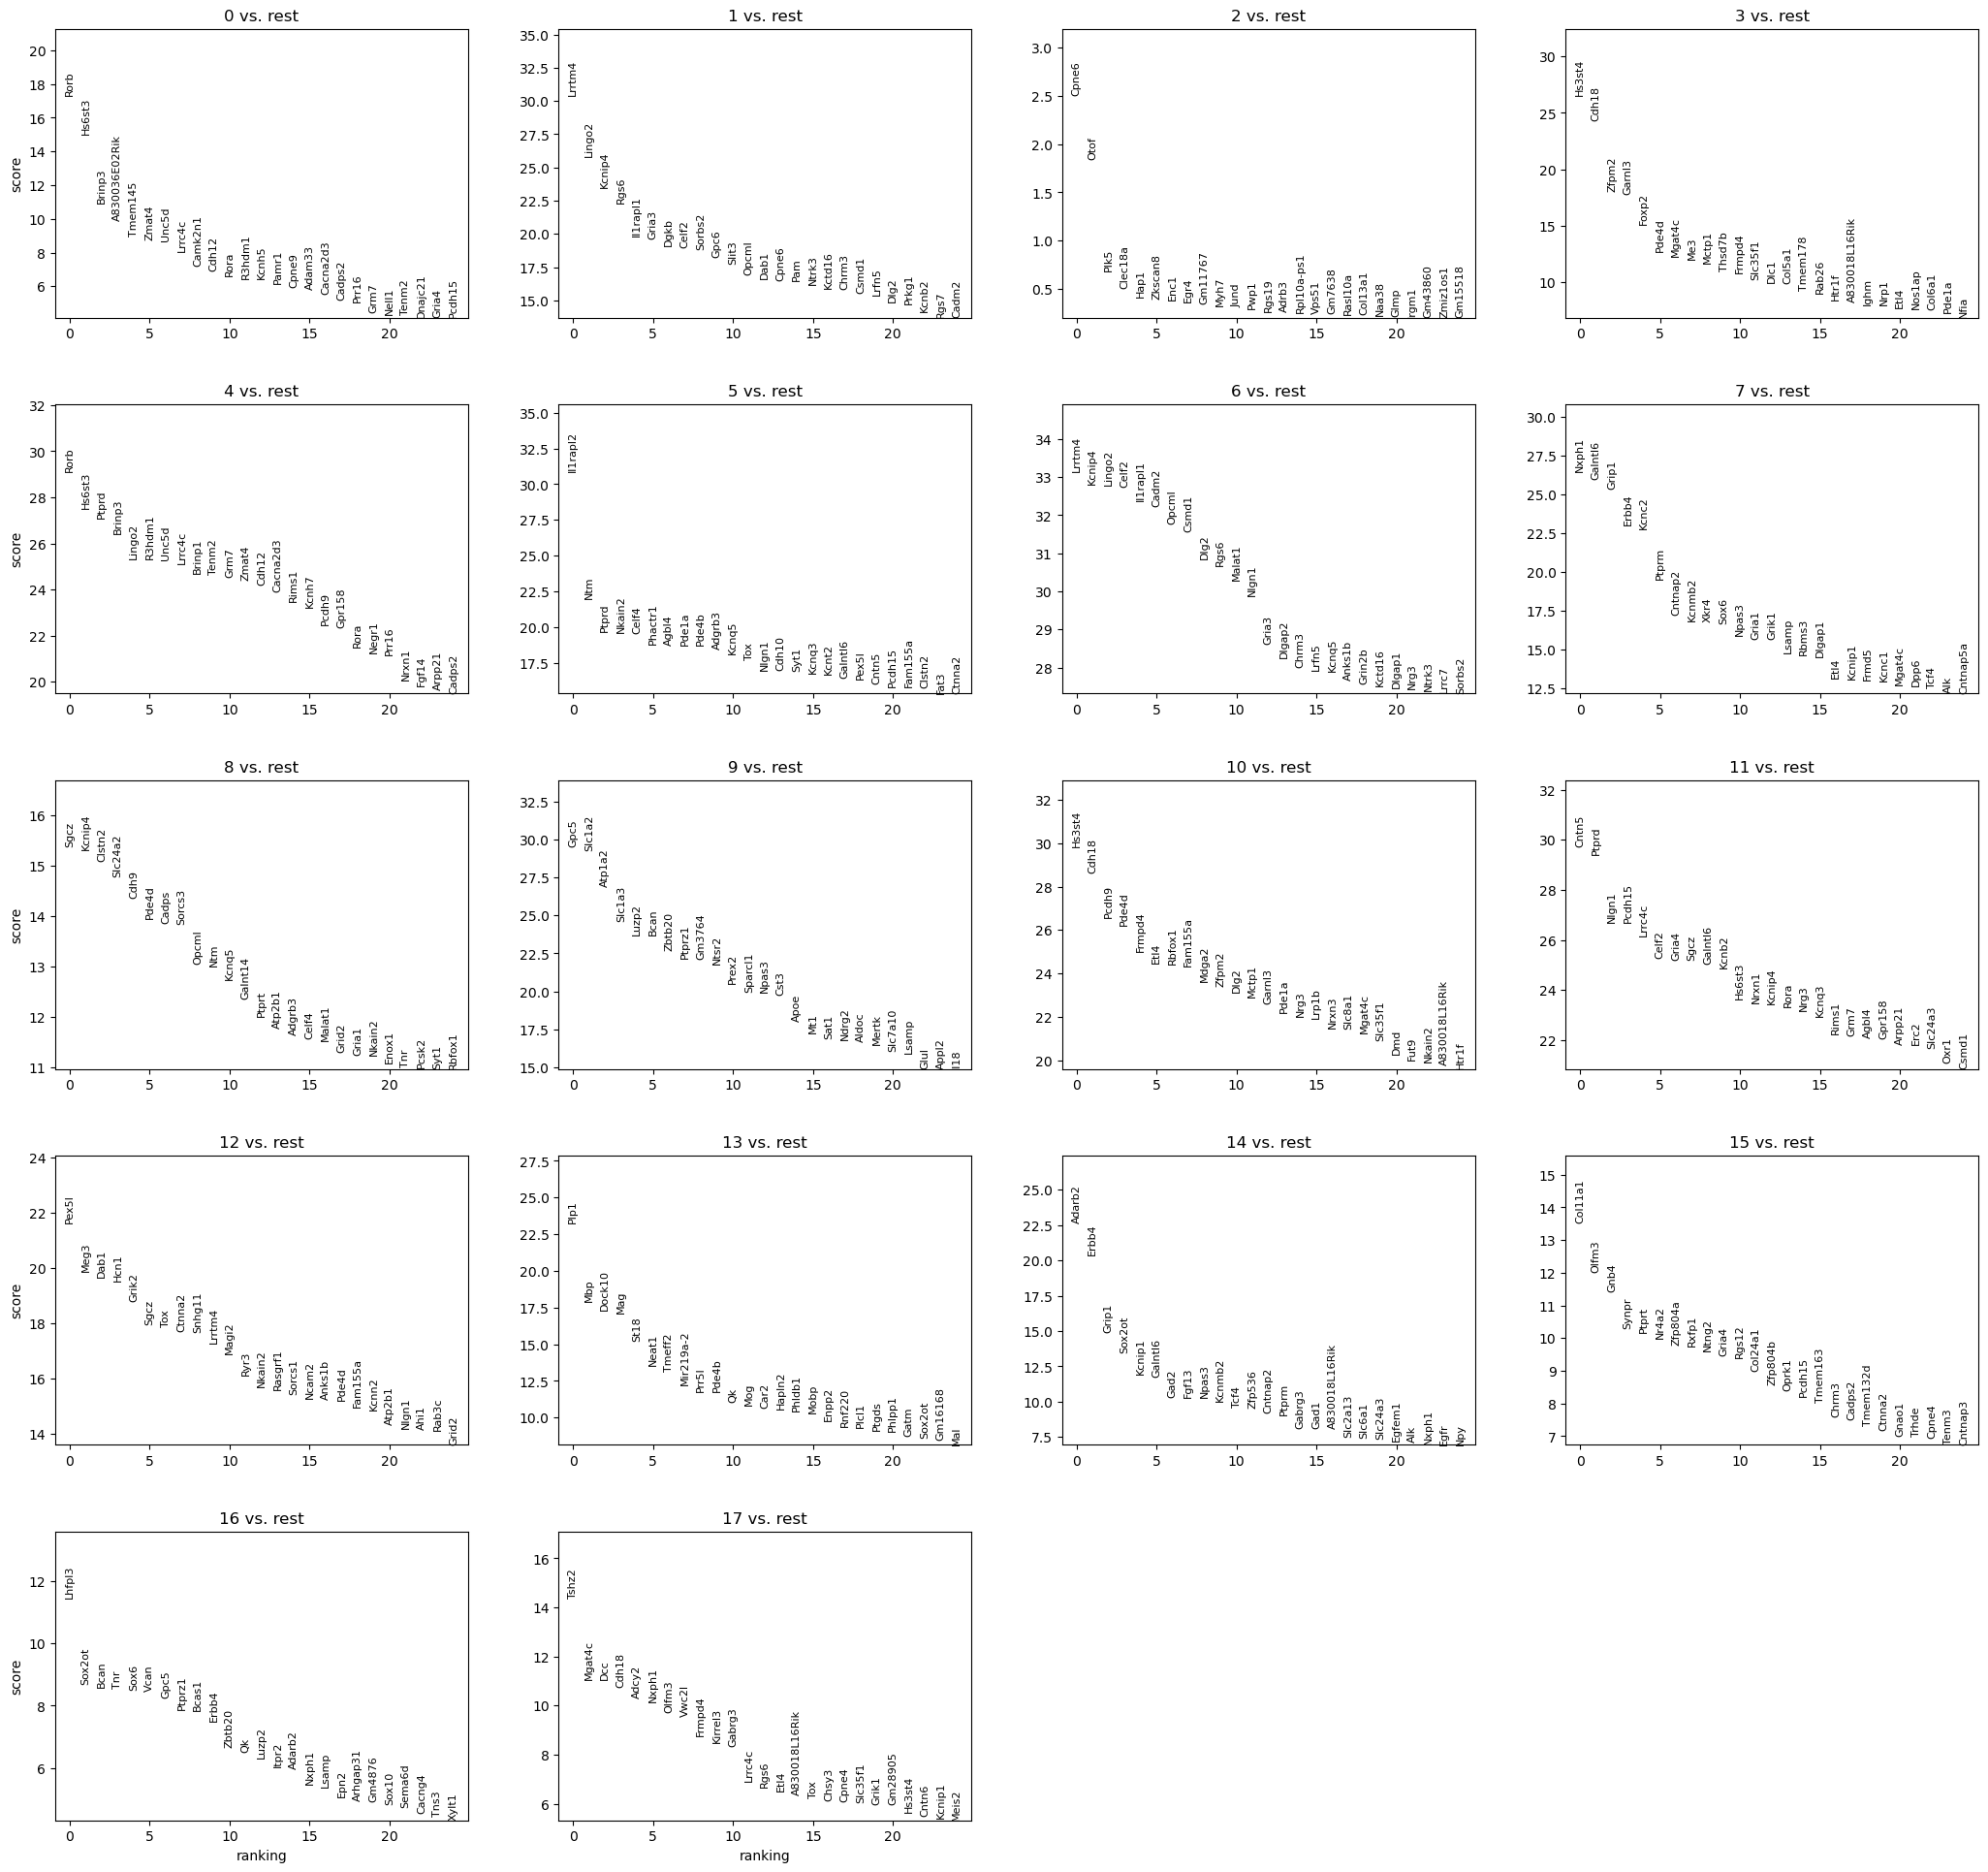

In [148]:
sc.tl.rank_genes_groups(annData,"leiden_1_0",method="wilcoxon")
#sharey=False表示每个子图的 y 轴刻度范围会根据对应的差异表达基因而自动调整
sc.pl.rank_genes_groups(annData,n_genes=25,sharey=False)

In [149]:
annData

AnnData object with n_obs × n_vars = 9190 × 2000
    obs: 'domain', 'cell_type', 'leiden_0_25', 'leiden_0_5', 'leiden_1_0', 'leiden_1_25', 'leiden_1_5'
    var: 'n_cells', 'highly_variable_var', 'highly_variable_pearson'
    uns: 'neighbors', 'umap', 'leiden', 'rank_genes_groups'
    obsm: 'scaled|X_pca', 'original|X_pca', 'X_umap'
    layers: 'counts', 'log1p_norm', 'analytic_pearson_residuals', 'scaled'
    obsp: 'distances', 'connectivities'

使用标记基因对聚类进行注释涉及将特定基因与每个聚类相关联，从而识别可能表示在这些聚类中的细胞类型或生物状态。

In [150]:
groups=annData.uns["rank_genes_groups"]
groups

{'params': {'groupby': 'leiden_1_0',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': True,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('Rorb', 'Lrrtm4', 'Cpne6', 'Hs3st4', 'Rorb', 'Il1rapl2', 'Lrrtm4', 'Nxph1', 'Sgcz', 'Gpc5', 'Hs3st4', 'Cntn5', 'Pex5l', 'Plp1', 'Adarb2', 'Col11a1', 'Lhfpl3', 'Tshz2'),
            ('Hs6st3', 'Lingo2', 'Otof', 'Cdh18', 'Hs6st3', 'Ntm', 'Kcnip4', 'Galntl6', 'Kcnip4', 'Slc1a2', 'Cdh18', 'Ptprd', 'Meg3', 'Mbp', 'Erbb4', 'Olfm3', 'Sox2ot', 'Mgat4c'),
            ('Brinp3', 'Kcnip4', 'Plk5', 'Zfpm2', 'Ptprd', 'Ptprd', 'Lingo2', 'Grip1', 'Clstn2', 'Atp1a2', 'Pcdh9', 'Nlgn1', 'Dab1', 'Dock10', 'Grip1', 'Gnb4', 'Bcan', 'Dcc'),
            ...,
            ('Lrrtm4', 'Grm3', 'Nrg3', 'Ntm', 'Dgkb', 'Pde7b', 'Zmat4', 'Celf2', 'Hs6st3', 'Csmd1', 'Unc5d', 'Robo3', 'Etl4', 'Nrg3', 'Arpp21', 'Lrrc4c', 'Ptprd', 'Auts2'),
            ('Rbfox1', 'Astn2', 'Pcdh9', 'Hs6st3', 'Gabrg3', 'Dscaml1', 'Htr1f', 'Arpp21', 'Gpc6', 'Snh

In [151]:
# 检查rank_genes_groups结果
annData.uns['rank_genes_groups'].keys()

dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])

In [152]:
#加上.dtype.names后，其中包含了结构化数组中各列的字段名称
groups_result=groups['names'].dtype.names
data={}
for group in groups_result:
    for key in ['names','pvals']:
        string=f"{group}_{key}"
        data[string]=groups[key][group]
df=pd.DataFrame(data)
df.head(25)

,0_names,0_pvals,1_names,1_pvals,2_names,2_pvals,3_names,3_pvals,4_names,4_pvals,...,13_names,13_pvals,14_names,14_pvals,15_names,15_pvals,16_names,16_pvals,17_names,17_pvals
0,Rorb,3.176546e-67,Lrrtm4,3.503772e-203,Cpne6,0.012241,Hs3st4,3.139186e-155,Rorb,1.257035e-186,...,Plp1,4.011202e-120,Adarb2,5.433094e-114,Col11a1,9.196029e-42,Lhfpl3,2.109494e-30,Tshz2,6.721362e-47
1,Hs6st3,5.799372e-51,Lingo2,3.781284e-147,Otof,0.064804,Cdh18,1.134683e-130,Hs6st3,6.389201e-167,...,Mbp,6.750468e-72,Erbb4,1.384483e-92,Olfm3,3.159324e-33,Sox2ot,3.409974e-18,Mgat4c,1.547987e-28
2,Brinp3,6.030366e-28,Kcnip4,5.362003e-122,Plk5,0.491150,Zfpm2,6.142051e-73,Ptprd,6.287902e-162,...,Dock10,2.143570e-67,Grip1,2.916425e-50,Gnb4,3.694080e-30,Bcan,7.561872e-18,Dcc,1.764550e-28
3,A830036E02Rik,4.455887e-23,Rgs6,1.274424e-110,Clec18a,0.610615,Garnl3,9.077152e-71,Brinp3,6.640894e-154,...,Mag,6.505983e-66,Sox2ot,4.086161e-41,Synpr,7.899363e-25,Tnr,1.144032e-17,Cdh18,6.147721e-27
4,Tmem145,2.053390e-19,Il1rapl1,7.904046e-88,Hap1,0.680781,Foxp2,7.952005e-52,Lingo2,9.159421e-142,...,St18,3.419683e-52,Kcnip1,6.178408e-33,Ptprt,2.438394e-24,Sox6,2.033126e-17,Adcy2,7.147461e-25
5,Zmat4,1.862260e-18,Gria3,1.297009e-85,Zkscan8,0.693958,Pde4d,3.071319e-37,R3hdm1,9.718395e-142,...,Neat1,4.582467e-42,Galntl6,5.896742e-32,Nr4a2,1.572672e-23,Vcan,2.730657e-17,Nxph1,2.649877e-24
6,Unc5d,3.866829e-18,Dgkb,2.394608e-81,Enc1,0.700930,Mgat4c,1.466625e-34,Unc5d,6.265391e-141,...,Tmeff2,1.106997e-39,Gad2,4.773059e-25,Zfp804a,1.082424e-22,Gpc5,1.439883e-16,Olfm3,2.876723e-22
7,Lrrc4c,6.291157e-16,Celf2,2.851593e-80,Egr4,0.718475,Me3,3.074172e-33,Lrrc4c,3.724666e-139,...,Mir219a-2,2.222100e-34,Fgf13,5.129327e-25,Rxfp1,1.544232e-22,Ptprz1,3.027939e-15,Vwc2l,1.056186e-21
8,Camk2n1,4.788688e-13,Sorbs2,4.690903e-79,Gm11767,0.729950,Mctp1,1.510076e-31,Brinp1,8.104240e-135,...,Prr5l,3.703643e-32,Npas3,7.915948e-25,Ntng2,7.953479e-22,Bcas1,4.792661e-15,Frmpd4,1.630839e-18
9,Cdh12,5.205785e-12,Gpc6,1.311609e-74,Myh7,0.744689,Thsd7b,6.631056e-28,Tenm2,2.704385e-134,...,Pde4b,4.441984e-32,Kcnmb2,8.728928e-24,Gria4,3.382812e-21,Erbb4,6.447032e-14,Kirrel3,1.912556e-17


解释如下：

每一行代表一个基因，每两列代表一个细胞群组，分别代表该基因在该细胞群组下表达的基因名称和p值（差异表达的置信度水平）

In [153]:
print(f"总共{df.shape[0]}个基因\n")

总共23350个基因



浏览每一个聚类的细胞个数

In [154]:
for i in annData.obs['leiden_1_0'].cat.categories:
  number = len(annData.obs[annData.obs['leiden_1_0']==i])
  print('the number of category {} is {}'.format(i,number))

the number of category 0 is 1134
the number of category 1 is 1092
the number of category 2 is 1066
the number of category 3 is 952
the number of category 4 is 586
the number of category 5 is 562
the number of category 6 is 514
the number of category 7 is 467
the number of category 8 is 446
the number of category 9 is 440
the number of category 10 is 390
the number of category 11 is 383
the number of category 12 is 327
the number of category 13 is 309
the number of category 14 is 195
the number of category 15 is 126
the number of category 16 is 113
the number of category 17 is 88


In [155]:
for i in annData.obs['cell_type'].cat.categories:
  number = len(annData.obs[annData.obs['cell_type']==i])
  print('the number of category {} is {}'.format(i,number))

the number of category Ast is 444
the number of category Clau is 146
the number of category E2Rasgrf2 is 2254
the number of category E3Rmst is 231
the number of category E3Rorb is 1443
the number of category E4Il1rapl2 is 620
the number of category E4Thsd7a is 470
the number of category E5Galnt14 is 532
the number of category E5Parm1 is 345
the number of category E5Sulf1 is 223
the number of category E5Tshz2 is 85
the number of category E6Tle4 is 1186
the number of category Endo is 22
the number of category InN is 100
the number of category InP is 274
the number of category InS is 206
the number of category InV is 129
the number of category Mic is 63
the number of category OPC is 98
the number of category OliI is 30
the number of category OliM is 270
the number of category Peri is 19


In [156]:
annData

AnnData object with n_obs × n_vars = 9190 × 2000
    obs: 'domain', 'cell_type', 'leiden_0_25', 'leiden_0_5', 'leiden_1_0', 'leiden_1_25', 'leiden_1_5'
    var: 'n_cells', 'highly_variable_var', 'highly_variable_pearson'
    uns: 'neighbors', 'umap', 'leiden', 'rank_genes_groups'
    obsm: 'scaled|X_pca', 'original|X_pca', 'X_umap'
    layers: 'counts', 'log1p_norm', 'analytic_pearson_residuals', 'scaled'
    obsp: 'distances', 'connectivities'

In [157]:
highly_variable_genes = annData.var["highly_variable_var"]
selected_features = annData[:, highly_variable_genes]
cluster('hv_leiden', selected_features)
calc_score('hv_leiden', selected_features)

分辨率		调整兰德系数
hv_leiden_0_25	0.373
hv_leiden_0_5	0.532
hv_leiden_1_0	0.447
hv_leiden_1_25	0.411
hv_leiden_1_5	0.416


在代码中，使用了不同的分辨率参数进行聚类（0.25、0.5、1.0、1.25、1.5）。较小的分辨率可能会导致过度细分的聚类结果，而较大的分辨率可能会导致欠分的聚类结果。调整兰德系数在分辨率值为0.5附近达到峰值，因为该分辨率下的聚类结果更好地反映了数据的内在结构。

In [165]:
for k in range(14, 25, 2):
    print(f"n_neighbors = {k}")
    sc.pp.neighbors(annData,n_neighbors=k,n_pcs=50,use_rep="scaled|X_pca")
    cluster('pca_leiden')
    calc_score('pca_leiden')

n_neighbors = 14
分辨率		调整兰德系数
pca_leiden_0_25	0.449
pca_leiden_0_5	0.527
pca_leiden_1_0	0.467
pca_leiden_1_25	0.445
pca_leiden_1_5	0.34
n_neighbors = 16
分辨率		调整兰德系数
pca_leiden_0_25	0.37
pca_leiden_0_5	0.521
pca_leiden_1_0	0.441
pca_leiden_1_25	0.424
pca_leiden_1_5	0.395
n_neighbors = 18
分辨率		调整兰德系数
pca_leiden_0_25	0.505
pca_leiden_0_5	0.503
pca_leiden_1_0	0.475
pca_leiden_1_25	0.454
pca_leiden_1_5	0.409
n_neighbors = 20
分辨率		调整兰德系数
pca_leiden_0_25	0.354
pca_leiden_0_5	0.546
pca_leiden_1_0	0.468
pca_leiden_1_25	0.431
pca_leiden_1_5	0.417
n_neighbors = 22
分辨率		调整兰德系数
pca_leiden_0_25	0.377
pca_leiden_0_5	0.488
pca_leiden_1_0	0.426
pca_leiden_1_25	0.453
pca_leiden_1_5	0.412
n_neighbors = 24
分辨率		调整兰德系数
pca_leiden_0_25	0.348
pca_leiden_0_5	0.499
pca_leiden_1_0	0.467
pca_leiden_1_25	0.402
pca_leiden_1_5	0.402


较小的n_neighbors值可能会导致过度拟合，而较大的n_neighbors值可能会导致欠拟合。在20左右，调整兰德系数可能会取到一个较为理想的值。

In [166]:
for k in range(30, 51, 5):
    print(f"n_pcs = {k}")
    sc.pp.neighbors(annData,n_neighbors=20,n_pcs=k,use_rep="scaled|X_pca")
    cluster('pca_leiden')
    calc_score('pca_leiden')

n_pcs = 30
分辨率		调整兰德系数
pca_leiden_0_25	0.413
pca_leiden_0_5	0.515
pca_leiden_1_0	0.413
pca_leiden_1_25	0.395
pca_leiden_1_5	0.379
n_pcs = 35
分辨率		调整兰德系数
pca_leiden_0_25	0.52
pca_leiden_0_5	0.518
pca_leiden_1_0	0.407
pca_leiden_1_25	0.375
pca_leiden_1_5	0.398
n_pcs = 40
分辨率		调整兰德系数
pca_leiden_0_25	0.483
pca_leiden_0_5	0.481
pca_leiden_1_0	0.491
pca_leiden_1_25	0.475
pca_leiden_1_5	0.43
n_pcs = 45
分辨率		调整兰德系数
pca_leiden_0_25	0.515
pca_leiden_0_5	0.516
pca_leiden_1_0	0.422
pca_leiden_1_25	0.424
pca_leiden_1_5	0.408
n_pcs = 50
分辨率		调整兰德系数
pca_leiden_0_25	0.354
pca_leiden_0_5	0.546
pca_leiden_1_0	0.468
pca_leiden_1_25	0.431
pca_leiden_1_5	0.417


通常来说，较小的n_pcs值可能会导致信息丢失，而较大的n_pcs值可能会包含过多的噪音或不相关的信息。但是实验结果显示，调整兰德系数在不同的n_pcs值下波动较大，难以找到明显的趋势。这可能是因为数据的特性或者聚类的复杂性使得调整兰德系数对n_neighbors值不敏感。

In [167]:
sc.pp.neighbors(annData,n_neighbors=20,n_pcs=50,use_rep="scaled|X_pca")
sc.tl.leiden(annData,key_added='pca_leiden_0_5',resolution=0.5)
labels_pred = annData.obs['cell_type']
labels_true = annData.obs['pca_leiden_0_5']
print(f'{round(metrics.adjusted_rand_score(labels_true, labels_pred), 3)}')

0.546


根据对比结果，当n_neighbors=35,n_pcs=50，resolution=0.5时能够取得相对理想的效果